# Implemetation

QMUL Machine Learning Society Hackhaton

#  Enhanced RES-NET 18 on Image Woof

This notebook is about training an improved version ResNet-18 network on the ImageWoof dataset.

The dataset was given in the format: /kaggle/input/the-queen-mary-machine-learning-hackathon-february/train/train/class0/ILSVRC2012_val_00000907.JPEG



In [2]:
# Installing any other dependencies
!pip install prettytable
!pip install tensorboard

The following block of code creates a csv file with the path of all train images as well as their respective class

In [3]:
import os
import csv

def save_directory_and_foldername_to_csv(folder_path, output_file):
    folder_name = os.path.basename(folder_path)
    with open(output_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Folder Name', 'File Path', 'File Name'])  # write header
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                complete_path = os.path.join(root, file)
                class_name = complete_path.split('/')[-2][-1]
                writer.writerow([complete_path, class_name])

# Usage

folder_path = '/kaggle/input/the-queen-mary-machine-learning-hackathon-february/train/train'  # replace with your folder path
output_file = '/kaggle/working/lables.csv'  # replace with your desired output file name
save_directory_and_foldername_to_csv(folder_path, output_file)

In [37]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm #nice graphic to show training progress
import time
from prettytable import PrettyTable
import pandas as pd
import os
import cv2
from PIL import Image
import copy
import random
# pytorch
from torch.utils.data import Dataset


from pandas.core.common import flatten
path = os.getcwd()
print(path)
import torch
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms.functional import InterpolationMode
from torch.optim.lr_scheduler import ReduceLROnPlateau
writer = SummaryWriter()

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device) #checking is GPU has been alocated

/kaggle/working
cuda


In [19]:
# parameters of batch size
# To keep constant as independant variables 
BATCH_SIZE=256 #Increased batch - improevement
num_epochs=20 
class_size=10
dropout_rate=0.0

The ImageWoof is provided in the competition and is already split into the train, test and validation categories.


The second improvement is applying data augmentation by randomly slightly rotate and translate the training images


In [20]:

# batch size, width, height, channels.  Bx128x128x3
# 128x128 images
IMAGE_DIMS = 128

transforms = transforms.Compose([
    transforms.Resize(size=(IMAGE_DIMS, IMAGE_DIMS)),
    # convert to rgb from greyscale.
    #v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    transforms.PILToTensor(),
    transforms.RandomPerspective(distortion_scale=0.6, p=0.4),
    # v2.GaussianBlur(kernel_size=(5, 11), sigma=(0.1, 0.2)),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.RandomAffine(degrees=(-15, 15)),
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

A custom dataset is used as well as the csv file created for labelling
The grayscale images present in the dataset were converted to RGB.

In [21]:
class CustomImageDataset(Dataset):
    """
        This class must inherit from the torch.utils.data.Dataset class.
        And contina functions __init__, __len__, and __getitem__.
    """
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        """Get the image and label at the index idx."""
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        #Image.open(img_path).convert("RGB").save(img_path)
        #image = read_image(img_path)
        image = Image.open(img_path).convert("RGB")
        
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform((label))
            
        return image, label


# test_data = CustomImageDataset("data/", "mnist_dataset/t10k-images.idx3-ubyte" )  #, transform=test_transform)
# print((test_data[0])[0].shape, "label value", test_data[0][1]) # Getting image from dataset.
train_data = CustomImageDataset("/kaggle/working/lables.csv", "/kaggle/input/the-queen-mary-machine-learning-hackathon-february/train/train", transform=transforms)

# Create a DataLoader, so we can iterate through the dataset in batches.
#train_loader = DataLoader(train_data, batch_size=64, shuffle=True, )

# Testing the dataloader.
# for i, (images, labels) in enumerate(train_loader):
#     print(i, images.shape, labels.shape)


train_size = int(0.8 * len(train_data))
test_size = len(train_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_data, [train_size, test_size])

# Create DataLoader for train and test sets
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Model
The following cell is the initialisation of the improved ResNet 18 model

In [38]:
class RES_NET_18(nn.Module):
    def __init__(self, class_size = 10, dropout_rate=0.0):  # conv_arch:
        super(RES_NET_18, self).__init__()
        self.out_classes = class_size
        self.drop = nn.Dropout(p=dropout_rate)
       # Define the ResNet18 improved architecture. Src: Bag of tricks https://arxiv.org/pdf/1812.01187

        # Original input block
        '''
        self.conv0 = nn.Conv2d(
            in_channels=1, out_channels=64,  # 1 for gray scale
            kernel_size=(7, 7),
            stride=2, padding=3, bias=False,
        ) 
        '''
        ################################################################
        # ResNet-C : Improved inout block from ResNet-C
        self.conv0_1 = nn.Conv2d(
            in_channels=3, out_channels=32,  # First input block 1 -> 32 stride 2
            kernel_size=(3, 3),
            stride=2, padding=1, bias=False,)
        self.conv0_2 = nn.Conv2d(
            in_channels=32, out_channels=32,  
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,)
        self.conv0_3 = nn.Conv2d(
            in_channels=32, out_channels=64,  
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,)
        ##################################################################

        self.bn0 = nn.BatchNorm2d(num_features=64)
        self.relu0 = nn.ReLU()
        self.maxpool0 = nn.MaxPool2d(
            kernel_size=(3, 3), stride=2, padding=1,
        )

        # First part of first conv block
        self.conv1_1 = nn.Conv2d(
            in_channels=64, out_channels=64,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.bn1_1 = nn.BatchNorm2d(num_features=64)
        self.relu1_1 = nn.ReLU()

        self.conv1_2 = nn.Conv2d(
            in_channels=64, out_channels=64,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.bn1_2 = nn.BatchNorm2d(num_features=64)
        self.relu1_2 = nn.ReLU()
        # Second part of first conv block
        self.conv1_3 = nn.Conv2d(
            in_channels=64, out_channels=64,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.bn1_3 = nn.BatchNorm2d(num_features=64)
        self.relu1_3 = nn.ReLU()

        self.conv1_4 = nn.Conv2d(
            in_channels=64, out_channels=64,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.bn1_4 = nn.BatchNorm2d(num_features=64)
        self.relu1_4 = nn.ReLU()

        # First part of second conv block, this layer changes features to 128
        self.conv2_1 = nn.Conv2d(
            in_channels=64, out_channels=128,
            kernel_size=(3, 3),
            stride=2, padding=1, bias=False,
        )
        self.bn2_1 = nn.BatchNorm2d(num_features=128)
        self.relu2_1 = nn.ReLU()

        self.conv2_2 = nn.Conv2d(
            in_channels=128, out_channels=128,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.bn2_2 = nn.BatchNorm2d(num_features=128)
        self.relu2_2 = nn.ReLU()

        self.dim_match_conv1 = nn.Conv2d(
            in_channels=64, out_channels=128,
            kernel_size=(1, 1),
            stride=2, bias=False,
        )
        self.dim_match_bn_1 = nn.BatchNorm2d(128)
        self.dim_match_relu_1 = nn.ReLU()
        # Second part of second conv block
        self.conv2_3 = nn.Conv2d(
            in_channels=128, out_channels=128,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.bn2_3 = nn.BatchNorm2d(num_features=128)
        self.relu2_3 = nn.ReLU()

        self.conv2_4 = nn.Conv2d(
            in_channels=128, out_channels=128,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.bn2_4 = nn.BatchNorm2d(num_features=128)
        self.relu2_4 = nn.ReLU()

        self.relu_after_add_1 = nn.ReLU()

        # First part of third conv block
        self.conv3_1 = nn.Conv2d(
            in_channels=128, out_channels=256,
            kernel_size=(3, 3),
            stride=2, padding=1, bias=False,
        )
        self.bn3_1 = nn.BatchNorm2d(num_features=256)
        self.relu3_1 = nn.ReLU()

        self.conv3_2 = nn.Conv2d(
            in_channels=256, out_channels=256,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.bn3_2 = nn.BatchNorm2d(num_features=256)
        self.relu3_2 = nn.ReLU()

        self.dim_match_conv2 = nn.Conv2d(
            in_channels=128, out_channels=256,
            kernel_size=(1, 1),
            stride=2, bias=False,
        )
        self.dim_match_bn_2 = nn.BatchNorm2d(256)
        self.dim_match_relu_2 = nn.ReLU()
        # Second part of third conv block
        self.conv3_3 = nn.Conv2d(
            in_channels=256, out_channels=256,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.bn3_3 = nn.BatchNorm2d(num_features=256)
        self.relu3_3 = nn.ReLU()

        self.conv3_4 = nn.Conv2d(
            in_channels=256, out_channels=256,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.bn3_4 = nn.BatchNorm2d(num_features=256)
        self.relu3_4 = nn.ReLU()

        self.relu_after_add_2 = nn.ReLU()

        # First part of fourth conv block
        self.conv4_1 = nn.Conv2d(
            in_channels=256, out_channels=512,
            kernel_size=(3, 3),
            stride=2, padding=1, bias=False,
        )
        self.bn4_1 = nn.BatchNorm2d(num_features=512)
        self.relu4_1 = nn.ReLU()

        self.conv4_2 = nn.Conv2d(
            in_channels=512, out_channels=512,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.bn4_2 = nn.BatchNorm2d(num_features=512)
        self.relu4_2 = nn.ReLU()

        self.dim_match_conv3 = nn.Conv2d(
            in_channels=256, out_channels=512,
            kernel_size=(1, 1),
            stride=2, bias=False,
        )
        self.dim_match_bn_3 = nn.BatchNorm2d(512)
        self.dim_match_relu_3 = nn.ReLU()
        # Second part of fourth conv block
        self.conv4_3 = nn.Conv2d(
            in_channels=512, out_channels=512,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.bn4_3 = nn.BatchNorm2d(num_features=512)
        self.relu4_3 = nn.ReLU()

        self.conv4_4 = nn.Conv2d(
            in_channels=512, out_channels=512,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.bn4_4 = nn.BatchNorm2d(num_features=512)
        self.relu4_4 = nn.ReLU()

        self.relu_after_add_3 = nn.ReLU()

        self.global_avg_pool = nn.AdaptiveAvgPool2d(
            output_size=(1, 1)
        )

        # Final FC layer - output layers depend on data set
        self.fc1 = nn.Linear(
            in_features=512, out_features=class_size  #class_size = 10
            
        )

        
        ##########################################################
        # This block is an improved to the ResNet-18 based on the ResNet-B and ResNet-D
        # Proposed by the paper "Bag of tricks for image classification by CNN"
        
        # The first block is a avererge pooling layer added from ResNet-D
        self.res_x_pool = nn.AvgPool2d(
            kernel_size=(2, 2), stride=2, padding=0,
        )
        # The other convolution fucntions are 1x1 proposed from ResNet-B
        self.res_x_conv_1 = nn.Conv2d(
            in_channels=64, out_channels=64,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.res_x_conv_2 = nn.Conv2d(
            in_channels=64, out_channels=128,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.res_x_conv_3 = nn.Conv2d(
            in_channels=128, out_channels=128,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.res_x_conv_4 = nn.Conv2d(
            in_channels=128, out_channels=256,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.res_x_conv_5 = nn.Conv2d(
            in_channels=256, out_channels=256,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.res_x_conv_6 = nn.Conv2d(
            in_channels=256, out_channels=512,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
        self.res_x_conv_7 = nn.Conv2d(
            in_channels=512, out_channels=512,
            kernel_size=(3, 3),
            stride=1, padding=1, bias=False,
        )
    ###############################################################

    def forward(self, x):
        ### Original:
        #x = self.conv0(x)
        x = x.float()
        ######## Input Improvement part ResNet-C
        x = self.conv0_1(x) #1 -> 32
        x = self.conv0_2(x) #32 -> 32
        x = self.conv0_3(x) #64 -> 64
        #########################
        
        x = self.bn0(x)
        x = self.relu0(x)
        x = self.maxpool0(x)
        res_x = x.detach().clone()  
        #detach(): This method creates a tensor that shares storage with the original tensor but excludes it from the computation graph
        # The x to be passed forward to the +2 layer
        

        # First residual block of first conv block
        x = self.conv1_1(x) # 64 -> 64
        x = self.bn1_1(x)
        x = self.relu1_1(x)
        x = self.conv1_2(x) # 64 -> 64
        x = self.bn1_2(x)
        x = self.relu1_2(x)

        ######## ResNet-B improvement
        res_x = self.res_x_conv_1(res_x) 
        ######################################
        x = x + res_x
        res_x = x.detach().clone()

        

        # Second residual block of first conv block
        x = self.conv1_3(x) # 64 -> 64
        x = self.bn1_3(x)
        x = self.relu1_3(x)
        x = self.conv1_3(x) # 64 -> 64
        x = self.bn1_3(x)
        x = self.relu1_3(x)

        ######## ResNet-B improvement
        res_x = self.res_x_conv_1(res_x) 
        ######################################
        x = x + res_x
        
        # res_x = x.detach().clone()
        res_x = x

        # First residual block of second conv block
        x = self.conv2_1(x) # 64 -> 128
        x = self.bn2_1(x)
        x = self.relu2_1(x)
        x = self.conv2_2(x) # 128 -> 128
        x = self.bn2_2(x)
        x = self.relu2_2(x)

        ######## ResNet-B/D improvement
        res_x = self.res_x_pool( res_x)
        res_x = self.res_x_conv_2(res_x)
        ######################################
 
        x = x + res_x
        
        x = self.dim_match_relu_1(x)
        # res_x = x.detach().clone()
        res_x = x


        # Second residual block of second conv block
        x = self.conv2_3(x) # 128 -> 128
        x = self.bn2_3(x)
        x = self.relu2_3(x) # 128 -> 128
        x = self.conv2_4(x) # 128 -> 128
        x = self.bn2_4(x)
        x = self.relu2_4(x) # 128 -> 128

        ######## ResNet-B improvement
        res_x = self.res_x_conv_3(res_x) 
        ######################################
        
        x = x + res_x
        x = self.relu_after_add_1(x)
        # res_x = x.detach().clone()
        res_x = x

        # First residual block of third conv block
        x = self.conv3_1(x) # 128 -> 256
        x = self.bn3_1(x)
        x = self.relu3_1(x) 
        x = self.conv3_2(x) # 256-> 256
        x = self.bn3_2(x)
        x = self.relu3_2(x)

        ######## ResNet-B/D improvement
        res_x = self.res_x_pool( res_x)
        res_x = self.res_x_conv_4(res_x)
        ######################################

        x = x + res_x
        
        x = self.dim_match_relu_2(x)
        # res_x = x.detach().clone()
        res_x = x
        
        # Second residual block of third conv block
        x = self.conv3_3(x) # 256-> 256
        x = self.bn3_3(x)
        x = self.relu3_3(x)
        x = self.conv3_4(x) # 256-> 256
        x = self.bn3_4(x)
        x = self.relu3_4(x)

        ######## ResNet-B improvement
        res_x = self.res_x_conv_5(res_x) 
        ######################################

        x = x + res_x
        
        x = self.relu_after_add_2(x)
        res_x = x

        # First residual block of fourth conv block
        x = self.conv4_1(x) # 256-> 512
        x = self.bn4_1(x)
        x = self.relu4_1(x)
        x = self.conv4_2(x) # 512-> 512
        x = self.bn4_2(x)
        x = self.relu4_2(x)

        ######## ResNet-B/D improvement
        res_x = self.res_x_pool( res_x)
        res_x = self.res_x_conv_6(res_x)
        ######################################
        
        x = x + res_x
        x = self.dim_match_relu_3(x)
        # res_x = x.detach().clone()
        res_x = x
    
        # Second residual block of third conv block
        x = self.conv4_3(x) # 512-> 512
        x = self.bn4_3(x)
        x = self.relu4_3(x)
        x = self.conv4_4(x) # 512-> 512
        x = self.bn4_4(x)
        x = self.relu4_4(x)

        ######## ResNet-B improvement
        res_x = self.res_x_conv_7(res_x) 
        ######################################
        x = x + res_x
        
        x = self.relu_after_add_3(x) #Relu Layer
        x = self.global_avg_pool(x)
       
        # Flatten after pooling to make output into a vector ready for FC layer
        x = torch.flatten(x, start_dim=1)
        # Final fc layer
        x = self.drop(x)
        x = self.fc1(x) #fully connected layer 512 -> 10
       

        return x
 

# Training the model

Some general tips for image classification in general are applied here.
Source: https://arxiv.org/abs/1812.01187

1. The batch size has been increased from 64 to 128 for efficient training and to provide less noisy accuracy.

2. Labelsmoothing cross entropy is applied instead of CrossEntropy as loss function to provide more generalisation when training the network.

3. A small learning rate is used for the first few epochs known as warming up and a Cosine Anealing scheduler is used afterwards which provide a large learning rate in the beginning and a low one at the end.

In [39]:
#Smooth label cross entroy loss function implemetation
# Source: https://gist.github.com/dpoulopoulos/64148f96cb073e7ddac33d3a877879ab

import torch.nn.functional as F

def linear_combination(x, y, epsilon):
    return epsilon * x + (1 - epsilon) * y


def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(loss / n, nll, self.epsilon)

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use cuda if available
model = RES_NET_18()  
model = model.to(device=device) #assign model to device
load_model = True
criterion = LabelSmoothingCrossEntropy(reduction='mean')
minimum_lr=5e-5
#optimizer = torch.optim.Adam(model.parameters(), lr= 5e-5) 
#optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3) 

optimizer = torch.optim.Adam(model.parameters()) 
#lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs , eta_min=minimum_lr, last_epoch=-1, verbose='deprecated')
warm_up_epochs = 3
#scheduler1 = 
#scheduler2 = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 20 , T_mult =1)

# Function to obtain current lr for an epoch
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
# Adding a learning rate scheduler to provide a smoother gradient descent less noisy accuracy
#lr_scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=num_epochs)

#model.load_state_dict(torch.load('resnet18_62.pth'))
model.to(device)
print(model)
print("Model has been tested and is working correctly.")
# Running the model with test data.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
# Define learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

RES_NET_18(
  (drop): Dropout(p=0.0, inplace=False)
  (conv0_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv0_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv0_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU()
  (maxpool0): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv1_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_2): ReLU()
  (conv1_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [41]:
start_time = time.time()

lr_list = []
loss_list = []
accuracy_list = []
loss_list_var = []
for epoch in tqdm(range(num_epochs)): 
    loss_var = 0
    '''
    if epoch < warm_up_epochs: 
        optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4)  # low initial  warmup learning rate

        
    elif epoch == warm_up_epochs: 
        optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) # higher learning rate + cosineanealing
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = (num_epochs -warm_up_epochs)  , T_mult =1)
    else:
        scheduler.step()
    
    lr_list.append(get_lr(optimizer))
    '''
    
    for idx, (images, labels) in enumerate(train_loader):
        
        # image and labels to CUDA when training 
        images = images.to(device=device)
        labels  = list(labels)
        labels =  torch.stack(labels)
        labels = labels.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        #Obtain a list of outputs from all images of the batch
        scores = model(images)
        # Compared the outputs with the true values
        loss = criterion(scores,labels)
        # Backpropagation
        loss.backward()
        #Updating weights 
        optimizer.step()
        #Summing the loss


        loss_var += loss.item()
        
        # Some verbose after 200 steps
        if idx%200==0:
            print(f'Epoch [{epoch+1}/{num_epochs}] || Step [{idx+1}/{len(train_loader)}] || Loss:{loss_var/len(train_loader)}')
    
    print(f"LR at epoch {epoch+1} || {get_lr(optimizer)}")


    print(f"Loss at epoch {epoch+1} || {loss_var/len(train_loader)}")
    print(f"Time per epoch {epoch+1} || {time.time()-start_time} s")
    
    #Testing the accuracy from the validation dataset after each epoch
    # no grad means no gradient descent and weights are not updated
    with torch.no_grad():
        correct = 0
        samples = 0
        for idx, (images, labels) in enumerate(val_loader):
            images = images.to(device=device) #obtain the images 
            labels  = list(labels)
            labels =  torch.stack(labels)
            labels = labels.to(device=device)
            outputs = model(images)  #obtain the outputs
            _, preds = outputs.max(1) #Rounding to nearest number
            correct += (preds == labels).sum() #counts correct predictions
            samples += preds.size(0)
        print(f"accuracy {float(correct) / float(samples) * 100:.2f} percentage || Correct {correct} out of {samples} samples")
        
        # Total loss for each epoch
        loss_list.append(loss_var/len(train_loader))
        loss_list_var.append(loss_var) 
        # Saving the accuracy per epoch
        acc = float(correct) / float(samples) * 100 # accuracy calculation
        accuracy_list.append(float(correct) / float(samples) * 100)

        writer.add_scalar("Loss/train", loss_var/len(train_loader) , epoch)
        writer.add_scalar("Accuracy/train", acc , epoch)
print(f"Total_training time || {time.time()-start_time} s ")

writer.flush()

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20] || Step [1/29] || Loss:0.08036615930754563
LR at epoch 1 || 0.01
Loss at epoch 1 || 2.2513590270075303
Time per epoch 1 || 68.28543591499329 s


  5%|▌         | 1/20 [01:23<26:29, 83.67s/it]

accuracy 19.94 percentage || Correct 360 out of 1805 samples
Epoch [2/20] || Step [1/29] || Loss:0.07473132528107741
LR at epoch 2 || 0.01
Loss at epoch 2 || 2.0623941585935395
Time per epoch 2 || 145.72077822685242 s


 10%|█         | 2/20 [02:39<23:44, 79.12s/it]

accuracy 22.60 percentage || Correct 408 out of 1805 samples
Epoch [3/20] || Step [1/29] || Loss:0.06719843683571651
LR at epoch 3 || 0.01
Loss at epoch 3 || 1.9739671740038642
Time per epoch 3 || 221.14665269851685 s


 15%|█▌        | 3/20 [03:54<21:53, 77.25s/it]

accuracy 24.54 percentage || Correct 443 out of 1805 samples
Epoch [4/20] || Step [1/29] || Loss:0.06720004821645803
LR at epoch 4 || 0.01
Loss at epoch 4 || 1.896350753718409
Time per epoch 4 || 296.62445187568665 s


 20%|██        | 4/20 [05:11<20:31, 76.95s/it]

accuracy 29.20 percentage || Correct 527 out of 1805 samples
Epoch [5/20] || Step [1/29] || Loss:0.06319130700210045
LR at epoch 5 || 0.01
Loss at epoch 5 || 1.8232732353539303
Time per epoch 5 || 373.060409784317 s


 25%|██▌       | 5/20 [06:26<19:07, 76.52s/it]

accuracy 31.97 percentage || Correct 577 out of 1805 samples
Epoch [6/20] || Step [1/29] || Loss:0.06150881997470198
LR at epoch 6 || 0.01
Loss at epoch 6 || 1.7529648747937432
Time per epoch 6 || 448.97205328941345 s


 30%|███       | 6/20 [07:42<17:47, 76.27s/it]

accuracy 33.85 percentage || Correct 611 out of 1805 samples
Epoch [7/20] || Step [1/29] || Loss:0.0551540522739805
LR at epoch 7 || 0.01
Loss at epoch 7 || 1.683600483269527
Time per epoch 7 || 524.7642736434937 s


 35%|███▌      | 7/20 [08:58<16:31, 76.27s/it]

accuracy 33.46 percentage || Correct 604 out of 1805 samples
Epoch [8/20] || Step [1/29] || Loss:0.05765436846634437
LR at epoch 8 || 0.01
Loss at epoch 8 || 1.6208386051243748
Time per epoch 8 || 600.0103099346161 s


 40%|████      | 8/20 [10:13<15:10, 75.88s/it]

accuracy 36.73 percentage || Correct 663 out of 1805 samples
Epoch [9/20] || Step [1/29] || Loss:0.052885384395204744
LR at epoch 9 || 0.01
Loss at epoch 9 || 1.5762627289212983
Time per epoch 9 || 676.0005836486816 s


 45%|████▌     | 9/20 [11:29<13:54, 75.84s/it]

accuracy 37.67 percentage || Correct 680 out of 1805 samples
Epoch [10/20] || Step [1/29] || Loss:0.05116377616750783
LR at epoch 10 || 0.01
Loss at epoch 10 || 1.4962722145277878
Time per epoch 10 || 751.9926860332489 s


 50%|█████     | 10/20 [12:46<12:39, 75.97s/it]

accuracy 39.72 percentage || Correct 717 out of 1805 samples
Epoch [11/20] || Step [1/29] || Loss:0.04920654461301606
LR at epoch 11 || 0.01
Loss at epoch 11 || 1.4375847043662235
Time per epoch 11 || 827.7617855072021 s


 55%|█████▌    | 11/20 [14:01<11:22, 75.78s/it]

accuracy 43.32 percentage || Correct 782 out of 1805 samples
Epoch [12/20] || Step [1/29] || Loss:0.04557664641018572
LR at epoch 12 || 0.01
Loss at epoch 12 || 1.4122772627863391
Time per epoch 12 || 903.2167313098907 s


 60%|██████    | 12/20 [15:17<10:07, 75.97s/it]

accuracy 43.82 percentage || Correct 791 out of 1805 samples
Epoch [13/20] || Step [1/29] || Loss:0.045823783710085116
LR at epoch 13 || 0.01
Loss at epoch 13 || 1.3373388915226376
Time per epoch 13 || 979.8608796596527 s


 65%|██████▌   | 13/20 [16:34<08:52, 76.13s/it]

accuracy 43.32 percentage || Correct 782 out of 1805 samples
Epoch [14/20] || Step [1/29] || Loss:0.044207326297102306
LR at epoch 14 || 0.01
Loss at epoch 14 || 1.2701059579849243
Time per epoch 14 || 1056.7512817382812 s


 70%|███████   | 14/20 [17:50<07:37, 76.19s/it]

accuracy 44.21 percentage || Correct 798 out of 1805 samples
Epoch [15/20] || Step [1/29] || Loss:0.04442510933711611
LR at epoch 15 || 0.01
Loss at epoch 15 || 1.2403998827112133
Time per epoch 15 || 1132.2893209457397 s


 75%|███████▌  | 15/20 [19:06<06:20, 76.04s/it]

accuracy 45.10 percentage || Correct 814 out of 1805 samples
Epoch [16/20] || Step [1/29] || Loss:0.03841733110362086
LR at epoch 16 || 0.01
Loss at epoch 16 || 1.225715345349805
Time per epoch 16 || 1207.9956641197205 s


 80%|████████  | 16/20 [20:21<05:03, 75.88s/it]

accuracy 47.09 percentage || Correct 850 out of 1805 samples
Epoch [17/20] || Step [1/29] || Loss:0.03314474122277621
LR at epoch 17 || 0.01
Loss at epoch 17 || 1.1436042004618152
Time per epoch 17 || 1283.6245851516724 s


 85%|████████▌ | 17/20 [21:37<03:47, 75.78s/it]

accuracy 49.14 percentage || Correct 887 out of 1805 samples
Epoch [18/20] || Step [1/29] || Loss:0.0346516124133406
LR at epoch 18 || 0.01
Loss at epoch 18 || 1.0578139095470822
Time per epoch 18 || 1359.319923877716 s


 90%|█████████ | 18/20 [22:53<02:31, 75.80s/it]

accuracy 47.87 percentage || Correct 864 out of 1805 samples
Epoch [19/20] || Step [1/29] || Loss:0.02915802495232944
LR at epoch 19 || 0.01
Loss at epoch 19 || 1.0045288903959866
Time per epoch 19 || 1434.7007477283478 s


 95%|█████████▌| 19/20 [24:08<01:15, 75.69s/it]

accuracy 49.09 percentage || Correct 886 out of 1805 samples
Epoch [20/20] || Step [1/29] || Loss:0.031198781112144733
LR at epoch 20 || 0.01
Loss at epoch 20 || 0.9842938328611439
Time per epoch 20 || 1509.7533178329468 s


100%|██████████| 20/20 [25:23<00:00, 76.18s/it]

accuracy 50.08 percentage || Correct 904 out of 1805 samples
Total_training time || 1523.6172971725464 s 


# Plots of learning rate, loss and accuracy

Text(0, 0.5, 'Learning rate')

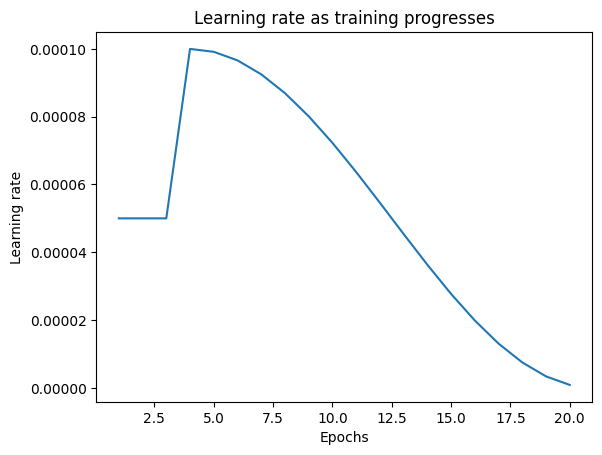

In [28]:
plt.plot(range(1,num_epochs+1),lr_list)
plt.title('Learning rate as training progresses')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')

Text(0, 0.5, 'Loss')

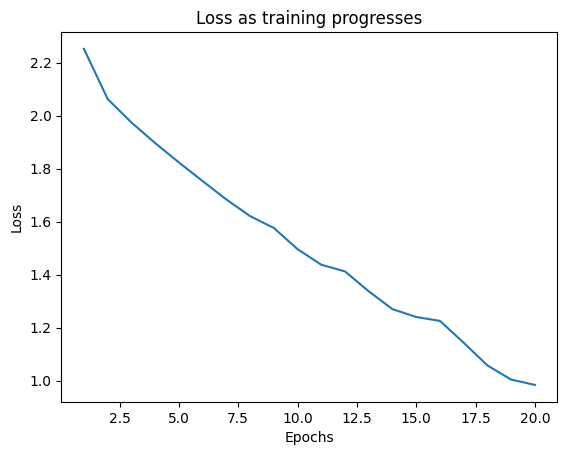

In [43]:
plt.plot(range(1,num_epochs+1),loss_list)
plt.title('Loss as training progresses')
plt.xlabel('Epochs')
plt.ylabel('Loss')

(0.0, 100.0)

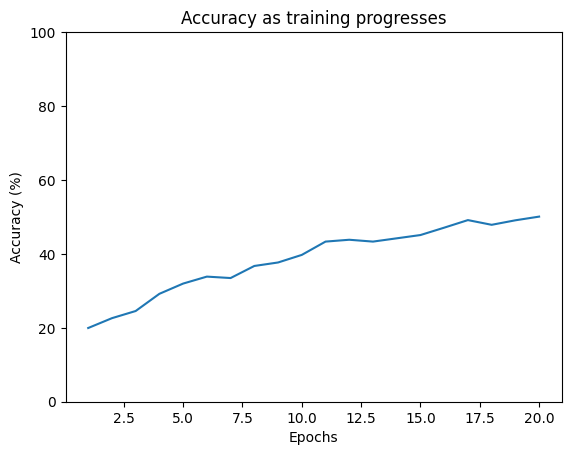

In [42]:
plt.plot(range(1,num_epochs+1),accuracy_list)
plt.title('Accuracy as training progresses')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

# Testing and Submission

In [ ]:
TEST_DIR = '/kaggle/input/the-queen-mary-machine-learning-hackathon-february/test/test'

model = ResNet18()
model.load_state_dict(torch.load('resnet18.pth'))
model.eval()
with open("submission.csv", "w") as file:
    for image in tqdm(images):
        img_path = os.path.join(TEST_DIR, str(image))
        Image.open(img_path).convert("RGB").save(img_path)
        img = Image.open(img_path)
        img = transform(img)  # Apply the defined transformation
        img = img.unsqueeze(0)  # Add a batch dimension

        with torch.no_grad():
            output = model(img)
            _, predicted = torch.max(output, 1)
            image_name = image.split(".")[0]
            file.write(f"{image_name},{predicted.item()}\n")